In [163]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
import math
import scipy
import scipy.signal as signal
import seaborn as sns

In [2]:
x = loadmat('C:/Users/rajra/OneDrive/Desktop/books/analysis of neural data/Ch8-spikes-1')

In [3]:
spike_low = x['SpikesLow']
spike_low = spike_low[0,]
spike_high = x['SpikesHigh']
spike_high = spike_high[0,]

In [4]:
def firing_rate(spike):
    firing_rate = spike.size/30
    return firing_rate

In [5]:
firing_rate(spike_low)

25.0

In [6]:
firing_rate(spike_high)

32.3

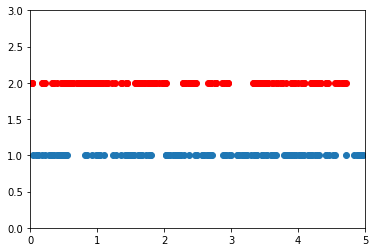

In [7]:
def plot_spike_times(spike_l,spike_h):
    plt.plot(spike_l,[1]*spike_l.size, 'o')
    plt.plot(spike_h,[2]*spike_h.size, 'o',c='red')
    plt.xlim(0,5)
    plt.ylim(0,3)
plot_spike_times(spike_low,spike_high)

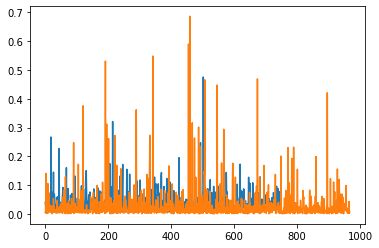

In [8]:
low_isi = np.diff(spike_low)
high_isi = np.diff(spike_high)
plt.plot(low_isi)
plt.plot(high_isi)

In [20]:
def isi_hist(isi):
    num_bins = 0.5/0.001
    n, bins, patches = plt.hist(isi,int(num_bins))
    


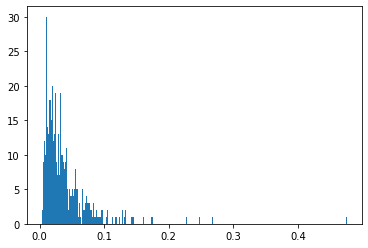

In [21]:
isi_hist(low_isi)

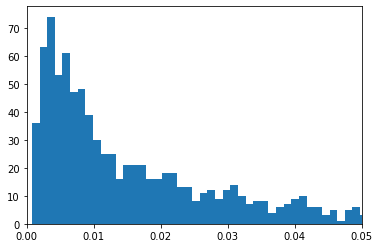

In [11]:
isi_hist(high_isi)

In [12]:
def inc_hist(spikes,time_bin):
    num_bins = 30/time_bin
    n, bins, patches = plt.hist(spikes,int(num_bins)+1)
    plt.close()
    fano_factor = np.var(n)/np.mean(n)
    plt.plot(np.arange(0,30+time_bin,time_bin),n,"o")
    return fano_factor,n
    

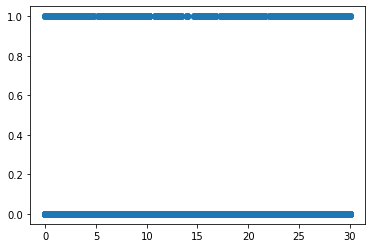

In [13]:
ff_low,incr_low = inc_hist(spike_low,0.001)
ff_high,incr_high = inc_hist(spike_high,0.001)


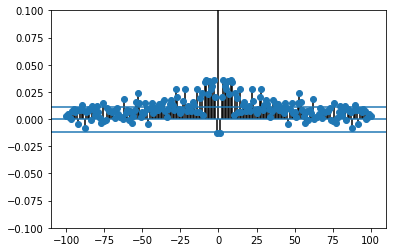

In [14]:
def autocorr(incr):
    lags,coef,_,_ = plt.acorr(incr-np.mean(incr),maxlags=100)
    plt.plot(np.arange(-100,101,1),coef,'o')
    plt.axhline(2/math.sqrt(incr.size))
    plt.axhline(-2/math.sqrt(incr.size))
    plt.ylim(-0.1,0.1)

autocorr(incr_high)

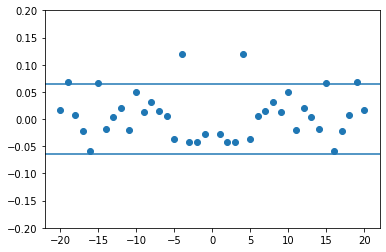

In [15]:
def autocorr_seq(isi):
    lags,coef,_,_ = plt.acorr(isi-np.mean(isi),maxlags=20)
    plt.close()
    plt.plot(np.arange(-20,21,1),coef,'o')
    plt.axhline(2/math.sqrt(isi.size))
    plt.axhline(-2/math.sqrt(isi.size))
    plt.ylim(-0.2,0.2)
autocorr_seq(high_isi)

In [197]:
def isi_model(isi):
    n,bins,_ = plt.hist(isi,bins = 500)
    plt.close()
    scaled_n = n/len(isi)
    bins = np.arange(0,0.5,0.001)
    plt.bar(np.arange(0,500,1),scaled_n)
    
    lam = 25
    model = lam*np.exp(-lam*np.arange(0,0.5,0.001))*0.001
    plt.plot(np.arange(0,500,1),model,c="r")


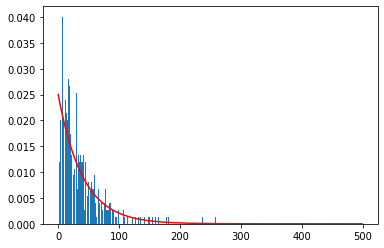

In [198]:
isi_model(low_isi)

In [212]:
def bootstrap_lam(low,high):
    mle_lam_dif0 = 1/np.mean(high) - 1/np.mean(low) 
    merged = np.append(low,high)
    mle_lam_diff = [0]*10000
    for i in range(10000):
        low_sample = np.random.choice(merged,len(low))
        high_sample = np.random.choice(merged,len(high))
        mle_lam_diff[i] = 1/np.mean(high_sample) - 1/np.mean(low_sample)
    plt.hist(mle_lam_diff,30)
    plt.axvline(mle_lam_dif0)
    plt.axvline(2*np.std(mle_lam_diff),c="r")
    plt.axvline(-2*np.std(mle_lam_diff),c="r")
        
    

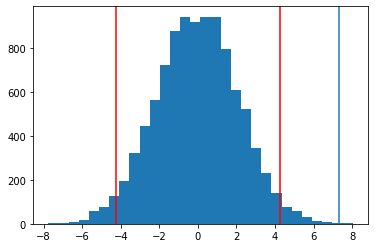

In [213]:
bootstrap_lam(low_isi,high_isi)

In [218]:
def compare_cdf(isi):
    n,bins,_ = plt.hist(isi,bins = 500)
    plt.close()
    scaled_n = n/len(isi)
    
    lam = 1/np.mean(isi)
    cdf_model = 1-np.exp(-lam*np.arange(0,0.5,0.001))
    cdf_data = np.cumsum(scaled_n)
    
    plt.plot(np.arange(0,0.5,0.001),cdf_data)
    plt.plot(np.arange(0,0.5,0.001),cdf_model,c="r")
    return cdf_data,cdf_model
    

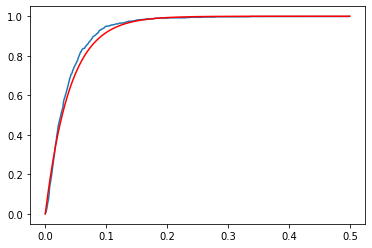

In [219]:
cdf_data,cdf_model = compare_cdf(low_isi)

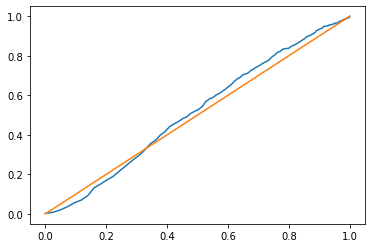

In [222]:
plt.plot(cdf_model,cdf_data)
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))

In [255]:
def inv_gaussian_model(isi):
    mn = np.mean(isi)
    lam = 1/np.mean(np.reciprocal(isi) - (1/mn))
    bins = np.arange(0,0.5,0.001)
    n,_,_ = plt.hist(isi,bins = 500)
    plt.close()
    scaled_n = n/len(isi)
    plt.bar(np.arange(0,500,1),scaled_n)
    
    model = [0]*500
    j=0
    for i in bins:
        if i == 0:
            model[j] = 0
        else:
            model_sqrt = math.sqrt(lam/(2*math.pi*(i**3)))
            model_exp = math.exp((-lam*((i-mn)**2))/(2*i*(mn**2)))
            model[j] = model_sqrt*model_exp*0.001
            j=j+1
    model[0] = 0
    plt.plot(np.arange(0,500,1),model,c="r")
    return model
    

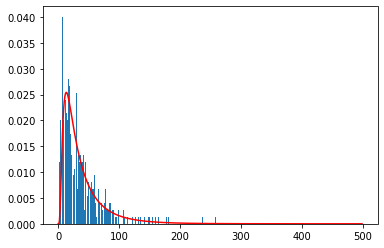

In [257]:
inv_gauss_low = inv_gaussian_model(low_isi)


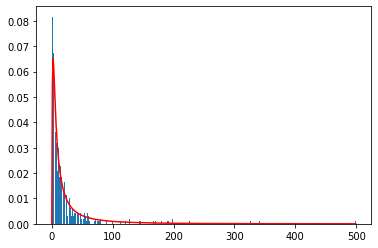

In [258]:
inv_gauss_high = inv_gaussian_model(high_isi)

In [262]:
def compare_cdf_invgauss(isi,model):
    n,bins,_ = plt.hist(isi,bins = 500)
    plt.close()
    scaled_n = n/len(isi)
    
    cdf_model = np.cumsum(model)
    cdf_data = np.cumsum(scaled_n)
    plt.plot(np.arange(0,0.5,0.001),cdf_data)
    plt.plot(np.arange(0,0.5,0.001),cdf_model,c="r")

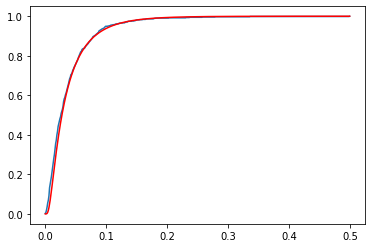

In [264]:
compare_cdf_invgauss(low_isi,inv_gauss_low)